# REUTERS TEXT CLASSIFICATION - MICHELE VISCIARELLI
In this notebook (written in Python3.7) I shall describe an example model for text classification using machine learning techniques. This notebook will contain:
<ol>
<li>A section dedicated on importing the data form the xml-like files in the dataset;</li>
<li>Cleaning and preparing the data for the machine learning computation;</li>
<li>An example of a machine learning solution for this task</li>
<li>Some analysis on the results and the work needed to improve the classification task.</li>
</ol>

In [1]:
import os
import re
import glob

import numpy as np
import pandas as pd
from datetime import datetime

from lxml import objectify

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers

Using TensorFlow backend.


In [2]:
# Import all the relevant files
files = sorted(glob.glob('data/*.sgm'))

['data/reut2-000.sgm',
 'data/reut2-001.sgm',
 'data/reut2-002.sgm',
 'data/reut2-003.sgm',
 'data/reut2-004.sgm',
 'data/reut2-005.sgm',
 'data/reut2-006.sgm',
 'data/reut2-007.sgm',
 'data/reut2-008.sgm',
 'data/reut2-009.sgm',
 'data/reut2-010.sgm',
 'data/reut2-011.sgm',
 'data/reut2-012.sgm',
 'data/reut2-013.sgm',
 'data/reut2-014.sgm',
 'data/reut2-015.sgm',
 'data/reut2-016.sgm',
 'data/reut2-017.sgm',
 'data/reut2-018.sgm',
 'data/reut2-019.sgm',
 'data/reut2-020.sgm',
 'data/reut2-021.sgm']

In [3]:
# Get the raw XML data, and generate a list with all the files
xml_files = []
for path in sorted(files):
    # open xml file
    xml_data = ''
    # Use 'rb' options because some of the .sgm files had some issues with encoding/decoding
    with open(path, 'rb') as f:
        xml_data = f.read().decode('utf-8','ignore')
        xml_files.append(xml_data)

Now that we have loded everything, the parsing phase shall begin. First, we recognize some "characteristic" strings that pertain to certain data that we want to keep. Then, we will generate a new list with all the "stripped docs": every entry in the list should contain only one article. 

In [4]:
# Pater for single doc entry in every file
doc_pattern = re.compile(r"<REUTERS.*?<\/REUTERS>", re.S)
# text bodies
body_pattern = re.compile(r"<BODY.*?<\/BODY>", re.S)
# dates
date_pattern = re.compile(r"[0-9]+-[A-Z]{3}-[0-9]{4} *[0-9]{2}:[0-9]{2}:[0-9]{2}\.[0-9]+", re.S)
# topics
topics_pattern = re.compile(r"<TOPICS><D>.*?<\/D>", re.S)
# place
places_pattern = re.compile(r"<PLACES><D>.*?<\/D>", re.S)
# people
people_pattern = re.compile(r"<PEOPLE.*?<\/PEOPLE>", re.S)
# orgs
orgs_pattern = re.compile(r"<ORGS.*?<\/ORGS>", re.S)
# exchanges
exch_pattern = re.compile(r"<EXCHANGES.*?<\/EXCHANGES>", re.S)
# companies
comp_pattern = re.compile(r"<COMPANIES.*?<\/COMPANIES>", re.S)
# author
author_pattern = re.compile(r"<AUTHOR.*?<\/AUTHOR>", re.S)
# title
title_pattern = re.compile(r"<TITLE.*?<\/TITLE>", re.S)

In [5]:
# Create a vector for all the separated docs
stripped_docs = []
for xml_file in xml_files:
    docs = doc_pattern.findall(xml_file)
    for i in range(len(docs)):
        stripped = docs[i].rstrip('\n')
        stripped_docs.append(stripped)

With the help of some "helper" functions (that are searching for specific patterns in the docs), we strip every single document of all the information that we need, and we save that in some vectors that later will be of use. 

In [6]:
# Helper function to find specific patterns in an xml record. 
def find_pattern(pattern, outlist, doc, topics = False, places = False, author = False, string = None):
    datalist = pattern.findall(doc)
    if datalist:
        if topics:
            datalist = re.sub(r"<TOPICS><D>", '', datalist[0])
            datalist = re.sub('</D>$', '', datalist)
            outlist.append(datalist)
        elif places:
            datalist = re.sub(r"<PLACES><D>", '', datalist[0])
            datalist = re.sub('</D>$', '', datalist)
            outlist.append(datalist)
        elif author:
            str1 = '<'+string+'>'
            str2 = '</'+string+'>$'
            datalist = re.sub(str1, '', datalist[0])
            datalist = re.sub(str2, '', datalist)
            datalist = re.sub(r"    by ", '', datalist)
            datalist = re.sub(r"    By ", '', datalist)
            datalist = re.sub(r"    BY ", '', datalist)
            datalist = re.sub(r", Reuters", '', datalist)
            outlist.append(datalist)
        else:
            str1 = '<'+string+'>'
            str2 = '</'+string+'>$'
            datalist = re.sub(str1, '', datalist[0])
            datalist = re.sub(str2, '', datalist)
            outlist.append(datalist)
    else: 
        outlist.append('')
        
    return outlist

In [7]:
# Checking if it's possible to parse the xml using objectify:
# xml_doc = objectify.fromstring(stripped_docs[0]) results in an error
# reading characters of the type: &#5;&#5;&#5;C 

# Let's deal with these, removing them from the file
faulty_string = re.compile(r"&#\d*;")

# support vectors for the quantities of interest
data = {
        'has_topics': [],
        'lewissplit': [],
        'cgisplit': [],
        'newid': [],
        'date': [],
        'text_body': [],
        'topic': [],
        'place': [],
        'people': [],
        'org': [],
        'exchange': [],
        'company': [],
        'author': [],
        'title': [],
       }

# Actual information gathering loop
for doc in stripped_docs:
    
    faulty_string = re.compile(r"&#\d*;")
    body = body_pattern.findall(doc)
    
    doc = faulty_string.sub('', doc)
    doc_obj = objectify.fromstring(doc)
    
    # List of headers keywords:
    # 0: TOPICS
    # 1: LEWISSPLIT
    # 2: CGISPLIT
    # 3: OLDID
    # 4: NEWID
    data['has_topics'].append(doc_obj.items()[0][1])
    data['lewissplit'].append(doc_obj.items()[1][1])
    data['cgisplit'].append(doc_obj.items()[2][1])
    data['newid'].append(doc_obj.items()[4][1])
    
    # dates (also dealing with missing values)
    date_obj = date_pattern.findall(doc)
    try:
        date_obj = datetime.strptime(date_obj[0],'%d-%b-%Y %H:%M:%S.%f')
        data['date'].append(date_obj)
    except IndexError:
        data['date'].append('')
    
    # gather data
    data['text_body'] = find_pattern(body_pattern, data['text_body'], doc, string = 'BODY')
    data['topic'] = find_pattern(topics_pattern, data['topic'] , doc, topics = True)
    data['place'] = find_pattern(places_pattern, data['place'], doc, places = True)
    data['people'] = find_pattern(people_pattern, data['people'], doc, string = 'PEOPLE')
    data['org'] = find_pattern(orgs_pattern, data['org'], doc, string = 'ORGS')
    data['exchange'] = find_pattern(exch_pattern, data['exchange'], doc, string = 'EXCHANGES')
    data['company'] = find_pattern(comp_pattern, data['company'], doc, string = 'COMPANIES')
    data['author'] = find_pattern(author_pattern, data['author'], doc, string = 'AUTHOR', author = True)
    data['title'] = find_pattern(title_pattern, data['title'], doc, string = 'TITLE')

With all the data nicely put in vectors, the easiest way to format it is to construct a DataFrame. They are easy to set up and to use, and they seem like the best strategy here to use. 

In [8]:
# Create Pandas dataframe with all the columns we are interested in
# NOTE: I'm dropping OLDID because it seems just an old id, as the name says.
# NEWID == id
columns = ['newid', 'cgisplit', 'lewissplit', 'has_topics', 
           'date', 'topic', 'place', 'people', 'org', 'exchange', 
           'company', 'title', 'text_body', 'author']
reuters_df = pd.DataFrame(columns = columns)

# Actual dataframe to be used
for col in columns:
    reuters_df[col] = data[col]

In [9]:
# Example of the finished dataframe
reuters_df.head()

,newid,cgisplit,lewissplit,has_topics,date,topic,place,people,org,exchange,company,title,text_body,author
0,1,TRAINING-SET,TRAIN,YES,1987-02-26 15:01:01.790,cocoa,el-salvador,,,,,BAHIA COCOA REVIEW,Showers continued throughout the week in\nthe ...,
1,2,TRAINING-SET,TRAIN,NO,1987-02-26 15:02:20.000,,usa,,,,,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America\nInc said...,
2,3,TRAINING-SET,TRAIN,NO,1987-02-26 15:03:27.510,,usa,,,,,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas\nCommerc...,
3,4,TRAINING-SET,TRAIN,NO,1987-02-26 15:07:13.720,,usa,,,,,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,BankAmerica Corp is not under\npressure to act...,Janie Gabbett
4,5,TRAINING-SET,TRAIN,YES,1987-02-26 15:10:44.600,grain,usa,,,,,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department\nreported the ...,


Now, we check for some issues in the data, and we deal with them. Mostly, we are going to focus on the text bodies and the topics, since these are the ones that are our features and targets, respectively. For example: there may be entries without text bodies, or without topics for us to use (here, the keyword 'has_topics' helps a lot). Also, we have to divide our set into train and test sets according to the 'lewissplit' column. 

In [10]:
# Some of the text bodies are empty. In the spirit of keeping it simple for the time being, 
# let's remove all the entries with empty text bodies
reuters_df = reuters_df[reuters_df['text_body'].str.len() > 0]

In [11]:
# First of all, let's divide the dataset in train and test with respect to LEWISSPLIT key
train_df = reuters_df[reuters_df['lewissplit'] == 'TRAIN']
test_df = reuters_df[reuters_df['lewissplit'] == 'TEST']

In [12]:
# Let's check if there are issues with has_topics keyword. To keep it simple for the moment, let's discard 
# all rows without topics (unfortunately, this leads to a loss of some data...)

# Assess if there's data with NO or BYPASS topics in the splits
print('NO rows in train: ', train_df[train_df['has_topics'] == 'NO'].shape[0])
print('NO rows in test', test_df[test_df['has_topics'] == 'NO'].shape[0])
print('BYPASS rows in train', train_df[train_df['has_topics'] == 'BYPASS'].shape[0])
print('BYPASS rows in test', test_df[test_df['has_topics'] == 'BYPASS'].shape[0])

# Drop rows
train_df = train_df[train_df['has_topics'] != 'NO']
train_df = train_df[train_df['has_topics'] != 'BYPASS']
test_df = test_df[test_df['has_topics'] != 'NO']
test_df = test_df[test_df['has_topics'] != 'BYPASS']

NO rows in train:  3687
NO rows in test 2449
BYPASS rows in train 416
BYPASS rows in test 0


Another subtle issue is the presence of topics that are only represented in the train or in the test set. These topics create issues, since in the best case scenario, the labels represented in the train set should be equal to the ones represented in the tes set. To keep it simple, we discard all the labels under-represented. 

In [13]:
# How many unique topic labels are there in the dataset? 
print('Unique labels in train: ', len(train_df['topic'].unique()))
print('Unique labels in test: ', len(test_df['topic'].unique()))

# It seems that there are discrepancies in the number of labels in train and test. 
# Usually, you want to have the same labels in the train and the test sets. 

labels_train = train_df['topic'].unique()
labels_test = test_df['topic'].unique()

# Remove labels that are only in the test set
test_df = test_df[~test_df['topic'].isin(np.setdiff1d(labels_test, labels_train))]

print('')
print('First cut re-evaluation:')
print('Unique labels in train: ', len(train_df['topic'].unique()))
print('Unique labels in test: ', len(test_df['topic'].unique()))

# Remove labels that are only in the train set
train_df = train_df[~train_df['topic'].isin(np.setdiff1d(labels_train, labels_test))]

print('')
print('Second cut re-evaluation:')
print('Unique labels in train: ', len(train_df['topic'].unique()))
print('Unique labels in test: ', len(test_df['topic'].unique()))

Unique labels in train:  78
Unique labels in test:  63

First cut re-evaluation:
Unique labels in train:  78
Unique labels in test:  60

Second cut re-evaluation:
Unique labels in train:  60
Unique labels in test:  60


Now, with all the checks completed, it's time to focus on the actual preparation of the dataset. Train text must be tokenized, and the categories of the test set must be converted in some One-hot encoding fashion. 

In [14]:
# Now, let's focus on the model. Our train set will be the text data itself. Our target, the topics. 

train_X = train_df['text_body'].values 
y_train = train_df['topic'].values
test_X = test_df['text_body'].values
y_test = test_df['topic'].values

In [15]:
# Constuct a vocabulary for the input text bodies, and convert it into tokens

# Define a tokenizer, fit it to our train split
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_X)

# Convert both train and test splits with the tokenizer fitted on the train set
X_train = tokenizer.texts_to_sequences(train_X)
X_test = tokenizer.texts_to_sequences(test_X)

In [16]:
# Let's look at the vocabulary size, and at the longest vector in our tokenized inputs
vocab_size = len(tokenizer.word_index) + 1
print('Vocabilary size: ', vocab_size)

maxlen = []
for i in range(len(X_train)):
    maxlen.append(len(X_train[i]))

maximum_sequence = max(maxlen)
print('Max input tokenized vector length: ', maximum_sequence)

Vocabilary size:  27723
Max input tokenized vector length:  1232


In [17]:
# Padding shorter sequences to the length of the maximum one
maxlen = maximum_sequence

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [18]:
# Encoding the targets
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

le = OneHotEncoder()
le.fit(y_train)

y_train = le.transform(y_train).toarray()
y_test = le.transform(y_test).toarray()

Let's now define some sort of a baseline model. Due to time constraints, it will be our only model, unfortunately. It's probably going to be unser-optimized (more on analysis of the results at the end), but it will serve as a first step for future evaluation.

In [44]:
# Let's build a very simple baseline model. In this case, a very simple MLR
# Remember: 60 unique classes in output!
embedding_dim = 20

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(60, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 1232, 20)          554460    
_________________________________________________________________
flatten_7 (Flatten)          (None, 24640)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                246410    
_________________________________________________________________
dense_20 (Dense)             (None, 60)                660       
Total params: 801,530
Trainable params: 801,530
Non-trainable params: 0
_________________________________________________________________


In [45]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

/home/michele/ENVIRONMENTS/machinelearning/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8728 samples, validate on 3001 samples
Epoch 1/20
8728/8728 [==============================] - 12s 1ms/step - loss: 2.0524 - accuracy: 0.3535 - val_loss: 1.6030 - val_accuracy: 0.4289
Epoch 2/20
8728/8728 [==============================] - 14s 2ms/step - loss: 1.1941 - accuracy: 0.6532 - val_loss: 1.1936 - val_accuracy: 0.7131
Epoch 3/20
8728/8728 [==============================] - 10s 1ms/step - loss: 0.8111 - accuracy: 0.7909 - val_loss: 1.0721 - val_accuracy: 0.7358
Epoch 4/20
8728/8728 [==============================] - 8s 965us/step - loss: 0.5797 - accuracy: 0.8454 - val_loss: 1.0232 - val_accuracy: 0.7534
Epoch 5/20
8728/8728 [==============================] - 8s 968us/step - loss: 0.4228 - accuracy: 0.8884 - val_loss: 1.0613 - val_accuracy: 0.7634
Epoch 6/20
8728/8728 [==============================] - 8s 956us/step - loss: 0.3097 - accuracy: 0.9192 - val_loss: 1.1426 - val_accuracy: 0.7584
Epoch 7/20
8728/8728 [==============================] - 11s 1ms/step - loss: 0.

In [46]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

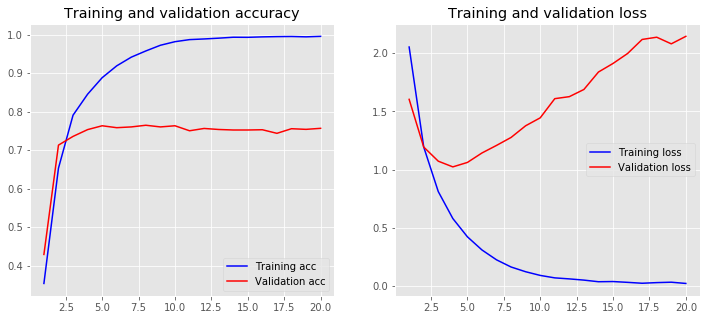

In [47]:
plot_history(history)

## RESULTS DISCUSSION
As the graphs suggest, the model is clearly overfitted. The difference between training and validation error and loss is too high, and rising after some epochs. Most probably it's related to the architecture of the neural network considered. Anyway, if someone wanted to catch the best "operation point" using this specific model, after the 4th epoch the validaiton loss starts to increase (and the validation accuracy to slightly decrease). Probably, 4 as the number of epochs is hte best for this hyperparameter in this case. <br>
In this Notebook, a "true" baseline identification is also lacking. It would be beneificial to have a 0th-order model to defer ourselves to, usually it's something related to some classical-machine-learning model, that can even be a linear regression, or a Random Forest Classifier. <br>
For this type of task, considering that the data can be clearly modelled as a time-series-alike, the use of Recurrent Neural Networks can provide better results. These types of networks are particularly suited for problems for which the input data is clearly structured in a sequence, as is in our case, and an exploration of the potential of that architecture is necessary. <br>
Another part that is missing due to the lack of time is a proper grid-type search for the best hyperparameter for the model. I would structure a search based on parallel execution of various scripts, each script pertaining to a different architecture (deeper, different number of neurons per layers, etc...) in which a GridSearch based on other parameters such as batch size, optimizer, activation function (and other hyperparameters not strictly related to the topology of the network) would be performed. 
<br> This would lead to a complete picture for the identification of the best performing model among all the ones considered. 